## Importing Libraries

In [ ]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import cv2

from keras import layers
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D


from PIL import Image
from tqdm import tqdm

!pip install livelossplot
from livelossplot import PlotLossesKeras

%matplotlib inline

In [ ]:
tr_df = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
tr_df['path'] = '../input/happy-whale-and-dolphin/train_images/' + tr_df['image']

pd_df = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv')
pd_df['path'] = '../input/happy-whale-and-dolphin/test_images/' + pd_df['image']

## Exploratory data analysis

In [ ]:
print("Glance at a dataset")
print(tr_df.head())

print("columns of the dataset are as follows")
print(tr_df.columns)

print("Samples count of the training data:")
print(len(tr_df))

print("Species count in the training data")
tr_df.species.value_counts()

## Data Cleaning
### After looking at the species we can see some duplicate values presenting similar entity
* `bottlenose_dolpin` and `bottlenose_dolphin`
* `kiler_whale` and `killer_whale`
* `beluga` and `beluga_whale`

### Due to extreme similarities between this two species we combined them 
* `globis` and `pilot_whale` into => `short_finned_pilot_whale`

In [ ]:
print("Number of unique species, Before fixing duplicate labels: ", tr_df['species'].nunique())

tr_df['species'].replace({'bottlenose_dolpin' : 'bottlenose_dolphin', 'kiler_whale' : 'killer_whale', 'beluga' : 'beluga_whale', 'globis' : 'short_finned_pilot_whale', 'pilot_whale' : 'short_finned_pilot_whale'}, inplace =True)

print('After data cleaning steps')
print("Total number of unique species: ", tr_df['species'].nunique())

tr_df['class'] = tr_df['species'].apply(lambda x: x.split('_')[-1])


In [ ]:
# glance at data after performing these steps.
tr_df.head()

## Checking missing data and images

In [ ]:
# print(tr_df.isna())

print(tr_df.isna().sum())
print(len(os.listdir('../input/happy-whale-and-dolphin/train_images')))

## Exploratory Data Analysis 
###by analyzing the distribution of class values

In [ ]:
plot = sns.countplot(x = tr_df['class'], color = '#087525')
sns.despine()
plot.set_title('Distribution of Class values\n', font = 'serif', x = 0.1, y=1, fontsize = 14);
plot.set_ylabel("Count", x = 0.02, font = 'serif', fontsize = 11)
plot.set_xlabel("Species", fontsize = 11, font = 'serif')

for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, -20),font = 'serif', textcoords = 'offset points', size = 14)

#### Pie chart of percentage of whale and dolphin in the dataset

In [ ]:
plt.figure(figsize=(5,5))
cl_count = tr_df.groupby(['class']).size().reset_index(name = 'counts')
colors = sns.color_palette('Paired')[0:9]
plt.pie(cl_count['counts'], labels=cl_count['class'], colors=colors, autopct='%1.1f%%')
plt.legend(loc='best')
plt.show()

#### Class distribution by each species

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(data=tr_df, y = 'species',  palette='crest', dodge=False)
plt.show()

#### class distribution by species for both Whale and Dolphin

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

whales = tr_df[tr_df['class']=='whale']
dolphins = tr_df[tr_df['class']!='whale']

sns.countplot(y="species", data=whales, order=whales.iloc[0:]["species"].value_counts().index, ax=ax[0], color = "#e38f10")
ax[0].set_title('Whales species Frequency')
ax[0].set_ylabel(None)
    
sns.countplot(y="species", data=dolphins,order=dolphins.iloc[0:]["species"].value_counts().index, ax=ax[1], color = "#2551a8")
ax[1].set_title('Dolphins species Frequency')
ax[1].set_ylabel(None)

plt.tight_layout()
plt.show()

#### Plot the value count graph of each individual

In [ ]:
tr_df['individual_id'].value_counts().plot()
plt.xticks(rotation=90)
plt.show()

#### Density estimation of each individuals

In [ ]:
np.log(tr_df['individual_id'].value_counts()).plot.kde()

#### Density estimation of individual for both whale and dolphin

In [ ]:
plt.figure(figsize = (15, 8))
sns.kdeplot(np.log(tr_df.loc[tr_df['class'] == 'dolphin']['individual_id'].value_counts()))
sns.kdeplot(np.log(tr_df.loc[tr_df['class'] == 'whale']['individual_id'].value_counts()))
plt.legend(labels = ['dolphin', 'whale'])
plt.show()

### Counting images based on individual_id

In [ ]:
tr_df['count'] = tr_df.groupby('individual_id',as_index=False)['individual_id'].transform(lambda x: x.count())

In [ ]:
tr_df.head()

#### Percentage of Individuals with greater than or equal to 5 and less then 21 images

In [ ]:
count = 0
for i in tr_df['count']:
    if(i > 4 and i <= 20):
        count += 1
print(count/len(tr_df))

<a id="image-resolutions"></a>
# Image Resolutions

In [ ]:
widths, heights = [], []

for path in tqdm(tr_df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
tr_df["height"] = heights
tr_df["width"] = widths
tr_df["dimension"] = tr_df["height"] * tr_df["width"]

### Color Analysis 

In [ ]:
def check_greyscale(Img_temp):
    w,h = Img_temp.size
    for i in range(w):
        for j in range(h):
            r,g,b = Img_temp.getpixel((i,j))
            if r != g != b: return False
    return True

sampFr = 0.1
#get our sampled images
grey_list = []
for img_name in tr_df['path'].sample(frac=sampFr):
    val = Image.open(img_name).convert('RGB')
    grey_list.append(check_greyscale(val))
print(np.sum(grey_list) / len(grey_list))
del grey_list

### Get mean intensity for each channel RGB <a name="get-mean-intensity-for-each-channel-RGB"></a>

In [ ]:
def rgb_get_m(row):
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.sum(img[:,:,0]), np.sum(img[:,:,1]), np.sum(img[:,:,2])

tqdm.pandas()
tr_df['R'], tr_df['G'], tr_df['B'] = zip(*tr_df.progress_apply(lambda row: rgb_get_m(row), axis=1) )

In [ ]:
def col_distribution(df, count):
    fig, axr = plt.subplots(count,2,figsize=(15,15))
    for idx, i in enumerate(np.random.choice(df['path'], count)):
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axr[idx,0].imshow(img)
        axr[idx,0].axis('off')
        axr[idx,1].set_title('R={:.0f}, G={:.0f}, B={:.0f} '.format(np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2]))) 
        x, y = np.histogram(img[:,:,0], bins=255)
        axr[idx,1].bar(y[:-1], x, label='R', alpha=0.8, color='red')
        x, y = np.histogram(img[:,:,1], bins=255)
        axr[idx,1].bar(y[:-1], x, label='G', alpha=0.8, color='green')
        x, y = np.histogram(img[:,:,2], bins=255)
        axr[idx,1].bar(y[:-1], x, label='B', alpha=0.8, color='blue')
        axr[idx,1].legend()
        axr[idx,1].axis('off')

In [ ]:
# Color distribution of red images

df = tr_df[((tr_df['B']*1.05) < tr_df['R']) & ((tr_df['G']*1.05) < tr_df['R'])]
col_distribution(df, 8)

In [ ]:
# Color distribution of Green images

df = tr_df[(tr_df['G'] > 1.05*tr_df['R']) & (tr_df['G'] > 1.05*tr_df['B'])]
col_distribution(df, 8)

In [ ]:
# Color distribution of Blue images

df = tr_df[(tr_df['B'] > 1.3*tr_df['R']) & (tr_df['B'] > 1.3*tr_df['G'])]
col_distribution(df, 8)

### We used following method for testing the accuracy of our model

We are going to decide the accuracy of our results using the Mean Average Precision @ 5 (MAP@5):

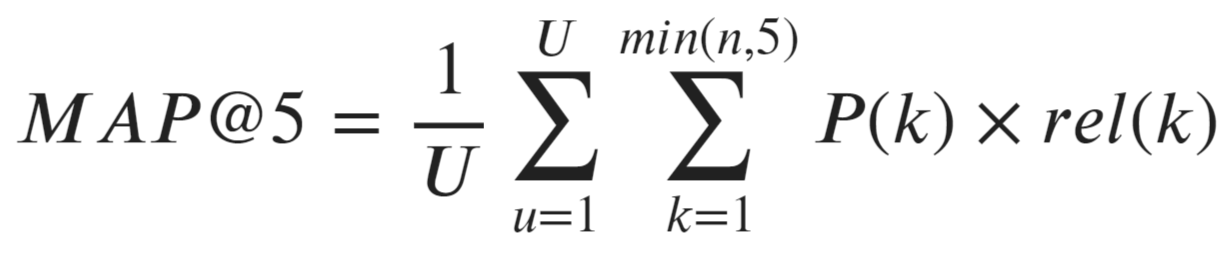

where U -> number of images
P(k) -> precision at cutoff k
n -> number of predictions per image
rel(k) -> indicator function = 1 if item at rank k is a relevant label, 0 otherwise.
